### An exploration of Transfer Entropy

Finding causality in systems is often the goal in the field of data-driven dynamics. Granger causality is the most famous measure of causality but it is known to have problems capturing nonlinear behaviour. We explore Transfer Entropy (TE) as a measure of causality in various kinds of systems after some inspiration from [1] where it shows collective behaviour and directionality of causation.


There are some open-source software to measure TE, granger causality etc:
1. The Information Dynamics Toolkit xl (IDTxl) - https://github.com/pwollstadt/IDTxl
2. Java Information Dynamics Toolkit (JIDT) - https://github.com/jlizier/jidt

Both these codebases are comprehensive. However, crucial underlying functions are written in Java. Although they can be used in Python using JPype, there are so many issues between JPype and the .jar file in the codebases that I wasn't able to run it after a lot of effort.

This notebook has code for Transfer Entropy only for discrete systems. We do explore some continuous systems but we discretize them to integers and that has its shortcomings. For continuous systems, I would reccomend getting the earlier software to work. Some of the code below might not work if you don't have the latest version of pandas

#### References

1. Razak, Fatimah Abdul, and Henrik Jeldtoft Jensen. "Quantifying ‘causality’in complex systems: understanding transfer entropy." PLoS One 9.6 (2014): e99462.


#### Dependencies
This notebook uses 
* numpy
* scipy
* matplotlib
* numba for just in time compilation
* pyitlib for entropy computations

###### Note to self
The transfer entropy functions needs non-negative integer values.

In [1]:
from numba import jit
from pyitlib import discrete_random_variable as drv

/home/jithin/anaconda3/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

The Transfer Entropy function

In [56]:
def TE(X,X_1,Y):
    '''
    Input:
        Takes times series X, X_1 (Which is X one step before)and Y
    Output:
        ans  - Measure of how Y causes X
    '''
    return drv.information_mutual_conditional(X,Y,X_1)
    

#### A Markov Chain

Here, we simulate a Hidden Markov Model. The Markov Chain describes the weather which could change between 'Rainy' and 'Sunny' or not change. Depending on the weather, people can decide to either 'walk', 'shop' or 'clean' with various probabilities. That creates a parallel chain of tasks. The code belows simulates the weather and the tasks.

We collect the simulated series and use transfer entropy to measure how much the weather influenced the task. With this code, we also incorporated delay. For example, if the lag was 3, people would decide on the task based on the weather 3 days ago.

Some of this code is from the wiki pages of Markov chains.

In [4]:
states = ('Rainy', 'Sunny')
 
observations = ('walk', 'shop', 'clean')
 
start_probability = {'Rainy': 0.6, 'Sunny': 0.4}
 
transition_probability = {
   'Rainy' : {'Rainy': 0.7, 'Sunny': 0.3},
   'Sunny' : {'Rainy': 0.4, 'Sunny': 0.6},
   }
 
emission_probability = {
   'Rainy' : {'walk': 0.1, 'shop': 0.4, 'clean': 0.5},
   'Sunny' : {'walk': 0.6, 'shop': 0.3, 'clean': 0.1},
   }
weather = []


What's the probability that one might go on a walk if it's rainy?

In [5]:
emission_probability['Rainy']['walk']

0.1

What's the probability that it's raining at the start of the simulation?

In [6]:
start_probability['Rainy']

0.6

Now, to get the data

In [7]:
def markov_data(steps = 200, lag = 0):
    weather = []
    task =[]
    if np.random.rand()<=start_probability['Rainy']:
        weather += ['Rainy']
    else: 
        weather += ['Sunny']
    for i in range(steps):
        if i - lag >= 0:
            weatherval = weather[i-lag]
        else:
            weatherval = weather[i]
        if weather[i] == 'Rainy':
            if np.random.rand()<=transition_probability['Rainy']['Rainy']:
                weather += ['Rainy']
            else:
                weather += ['Sunny']
        else:
            if np.random.rand()<=transition_probability['Sunny']['Rainy']:
                weather += ['Rainy']
            else:
                weather += ['Sunny']
        if weatherval == 'Rainy':
            rval = np.random.rand()
            if rval<=emission_probability['Rainy']['walk']+emission_probability['Rainy']['shop']:
                if rval <= emission_probability['Rainy']['walk']:
                    task += ['walk']
                else:
                    task += ['shop']
            else:
                task += ['clean']
        else:
            rval = np.random.rand()
            if rval<=emission_probability['Sunny']['walk']+emission_probability['Sunny']['shop']:
                if rval <= emission_probability['Sunny']['walk']:
                    task += ['walk']
                else:
                    task += ['shop']
            else:
                task += ['clean']
    return weather[:-1], task

A function to analyze results

In [30]:

def analyser(X, Y,maxlag=5, startid=0 , name = 'fig.png'):
    lagrange = [i for i in range(maxlag)]
    anslist = np.zeros(len(lagrange))
    for i in lagrange:
        if i ==0:
            ans  = TE(X[startid:],X[startid-1:-1],Y[startid:])
            anslist[i]= ans 
        else:
            ans  = TE(X[startid:],X[startid-1:-1],Y[startid-i:-i])
            anslist[i]= ans
    plt.plot(lagrange,anslist, '-o')
    plt.xlabel('Lag')
    plt.ylabel('Transfer Entropy')
    
    plt.savefig(name)
    plt.show()
    return anslist

Creating two data sets - one with lag 0 and the other lag 3 

In [25]:
weather,task = markov_data(2000,0)
weather_lag3,task_lag3 =markov_data(2000,3)

weather = np.array(weather)
weather[weather == 'Rainy'] = 1
weather[weather == 'Sunny'] = 2
weather = weather.astype(np.float)

weather_lag3 = np.array(weather_lag3)
weather_lag3[weather_lag3 == 'Rainy'] = 1
weather_lag3[weather_lag3 == 'Sunny'] = 2
weather_lag3 = weather_lag3.astype(np.float)

task = np.array(task)
task[task== 'walk']=1
task[task== 'shop']=2
task[task== 'clean']=3
task = task.astype(np.float)

task_lag3 = np.array(task_lag3)
task_lag3[task_lag3 == 'walk']=1
task_lag3[task_lag3== 'shop']=2
task_lag3[task_lag3== 'clean']=3
task_lag3 = task_lag3.astype(np.float)

In [28]:
for i in range(1,20):
    a  = TE(task[1000:],task[999:-1],weather[1000-i:-i])
    print(a,i)

0.02332387917042955 1
0.009927036224395502 2
0.0037969931852483985 3
0.0027061185557706313 4
0.0008350712320306375 5
0.0028472678788091788 6
0.0023062576014132308 7
0.0030338542628609577 8
0.0028737079925316156 9
0.005999943092549254 10
0.002611991018272919 11
0.004308321729015185 12
0.003936252193201151 13
0.005239649668378421 14
0.002463826364133448 15
0.0040769950053010096 16
0.0017472557016742218 17
0.0037758866412114234 18
0.0028506590028334333 19


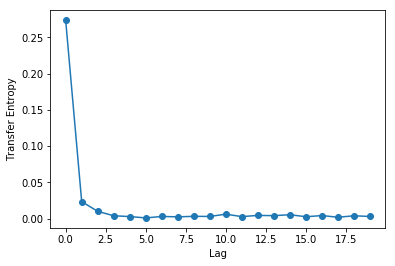

array([0.27356078, 0.02332388, 0.00992704, 0.00379699, 0.00270612,
       0.00083507, 0.00284727, 0.00230626, 0.00303385, 0.00287371,
       0.00599994, 0.00261199, 0.00430832, 0.00393625, 0.00523965,
       0.00246383, 0.004077  , 0.00174726, 0.00377589, 0.00285066])

In [34]:
analyser(task,weather,20, 1000, name  = 'taskgivenweather.pdf')

##### Interpretations

This shows that the task today is influenced by the weather today much more than the weather on any other day.

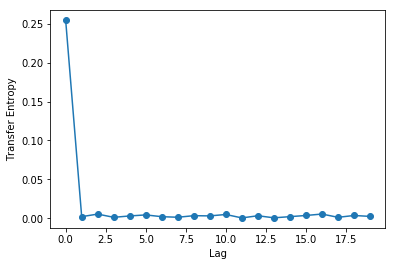

array([0.25461308, 0.00199367, 0.00527395, 0.00113086, 0.00289664,
       0.00422816, 0.00194365, 0.00122208, 0.00323464, 0.00295945,
       0.0047732 , 0.00036215, 0.0031499 , 0.00048467, 0.00198104,
       0.00349824, 0.00534263, 0.00113099, 0.00347873, 0.00232558])

In [31]:
analyser(weather,task,20, 1000, name  = 'weathergiventask.pdf')

##### Interpretations

This shows that the weather today is influenced by the task today much more than the task on any other day. We know this is not possible but the Markov chain is built with no external cause of weather. So, the correlation from the tasks get interpretated as causation.

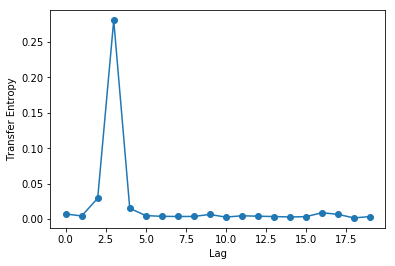

array([0.00726374, 0.0044277 , 0.02946929, 0.28050354, 0.01520692,
       0.00495278, 0.00391709, 0.00368131, 0.00376765, 0.00655944,
       0.00280924, 0.00469087, 0.00409483, 0.00362025, 0.00301027,
       0.00343688, 0.00902171, 0.00669128, 0.00167103, 0.00356811])

In [32]:
analyser(task_lag3,weather_lag3,20, 1000, name  = 'taskgivenweatherlag3.pdf')

##### Interpretations

With the lagged markov chain, we see correctly that the task is influenced by the weather 3 days ago.

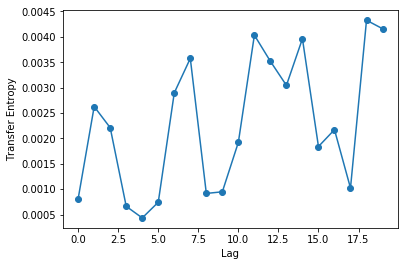

array([0.00081296, 0.00262632, 0.00221001, 0.00066162, 0.00043364,
       0.00074267, 0.00289663, 0.00357474, 0.00091568, 0.00094804,
       0.00192242, 0.00403236, 0.00351769, 0.00304358, 0.00396238,
       0.00183909, 0.00217135, 0.00102132, 0.00432619, 0.00415981])

In [33]:
analyser(weather_lag3,task_lag3,20, 1000, name  = 'weathergiventasklag3.pdf')

##### Interpretations

##### Interpretations

This shows that the task today is influenced by the weather today much more than the weather on any other day.

#### A random sequence

In [35]:
def random_data(steps =200,intf =5):
    X = [np.random.randint(0,intf) for i in range(steps)]
    Y = [np.random.randint(0,intf) for i in range(steps)]
    return X,Y
RandX,RandY = random_data(20000,10)

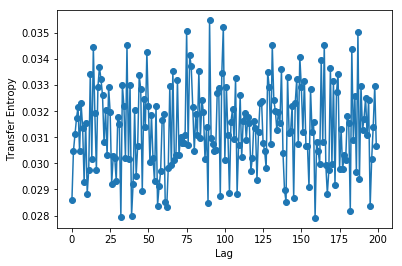

array([0.02858523, 0.03047773, 0.03111132, 0.03172524, 0.03216563,
       0.0304653 , 0.03230286, 0.03136634, 0.02927355, 0.03152735,
       0.02884226, 0.0297593 , 0.03342846, 0.03017652, 0.03445648,
       0.03192259, 0.02973792, 0.03291409, 0.03369645, 0.03322114,
       0.03261863, 0.03080773, 0.03202826, 0.03031201, 0.03291727,
       0.0319631 , 0.02921471, 0.03028297, 0.03021642, 0.02930691,
       0.03179409, 0.03151969, 0.02793117, 0.03300333, 0.03219468,
       0.03021903, 0.03454031, 0.03017984, 0.03301818, 0.02797301,
       0.0292175 , 0.03204181, 0.02952794, 0.03066504, 0.033372  ,
       0.03284603, 0.02895724, 0.03247123, 0.03140416, 0.03427127,
       0.03221172, 0.03003695, 0.03184809, 0.03021441, 0.02932358,
       0.0321918 , 0.02838307, 0.02911658, 0.02968803, 0.03166227,
       0.03189548, 0.02853001, 0.02832401, 0.02983394, 0.03296612,
       0.02992851, 0.03355292, 0.03014757, 0.03030752, 0.03319926,
       0.03032006, 0.03100449, 0.03078075, 0.03076803, 0.03106

In [36]:
analyser(RandX,RandY,200, 1000, name  = 'random.pdf')

##### Interpretations

This shows very little causation at any lag.

#### Lorenz differential equation system

In [63]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)
StateX = states[:,0]
StateY = states[:,1]
StateZ = states[:,2]

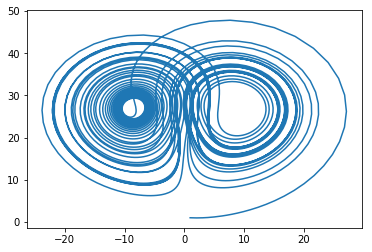

In [64]:
plt.plot(StateY,StateZ)
plt.show()

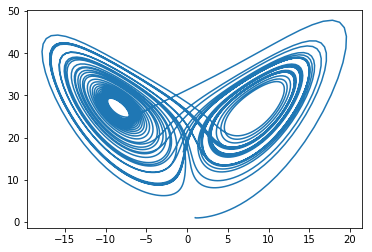

In [65]:
plt.plot(StateX,StateZ)
plt.show()

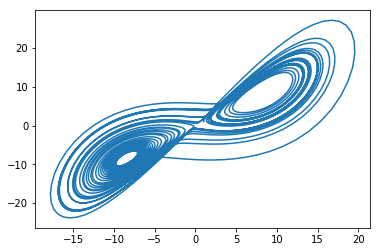

In [66]:
plt.plot(StateX,StateY)
plt.show()

My code is only for discete data but the Lorenz system is continuous. To deal with that, I make the data discrete by converting the floats to integers. (Don't judge me)

It isn't a terrible thing to do if you look below.

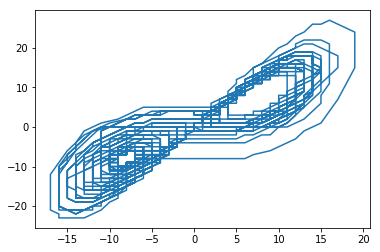

In [67]:
plt.plot(StateX.astype(int),StateY.astype(int))
plt.show()

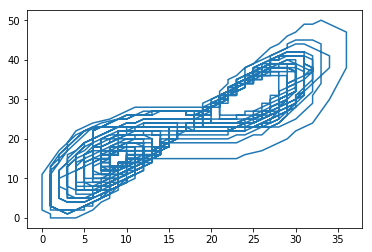

In [68]:
StateX = StateX.astype(int)-min(StateX.astype(int))
StateY = StateY.astype(int)-min(StateY.astype(int))
StateZ = StateZ.astype(int)-min(StateZ.astype(int))
plt.plot(StateX,StateY)
plt.show()

In [70]:
StateZ

array([ 1,  0,  0, ..., 17, 17, 16])

In [73]:
analyser(StateX,StateY, name  = 'LorenzYgivenZ.pdf')

ValueError: arg Z contains no elements

In [75]:
analyser(StateZ,StateY, name  = 'LorenzZgivenY.pdf')

ValueError: arg Z contains no elements

##### Interpretations

We are unable to run transfer entropy on these dynamics. The fact that we are able to do so on all other systems might imply that chaotic continuous dynamics might not be compatible with discrete transfer entropy measurement

#### Nicholson-Bailey model

We discretized a dynamical system in the previous example. So, why not do discrete dynamics from the start?

Host(H) - Parasite(P) dynamics

$H_{t+1} = kH_te^{-aP_t}$


$P_{t+1} = cH_t(1-e^{-aP_t})$

Here, H influences P and P influences H back.

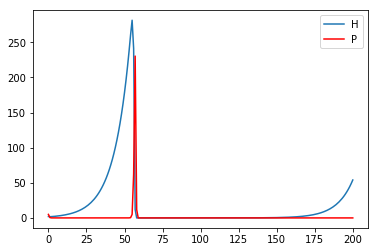

In [74]:
def NBmodel(IC,steps =200):
    c = 1
    a = .05
    k =1.1
    H = np.zeros(steps+1)
    P = np.zeros(steps+1)
    H[0]= IC[0]
    P[0]= IC[1]
    for i in range(steps):
        H[i+1]= k*H[i]*np.exp(-a*P[i])
        P[i+1]= c*H[i]*(1-np.exp(-a*P[i]))
    return H,P
H,P = NBmodel([2,5])
plt.plot(H,label = 'H')
plt.plot(P,'r',label = 'P')
plt.legend()
plt.show()    

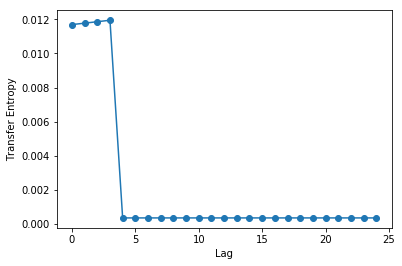

array([0.01169591, 0.01178028, 0.0118655 , 0.01195159, 0.00034266,
       0.00034266, 0.00034266, 0.00034266, 0.00034266, 0.00034266,
       0.00034266, 0.00034266, 0.00034266, 0.00034266, 0.00034266,
       0.00034266, 0.00034266, 0.00034266, 0.00034266, 0.00034266,
       0.00034266, 0.00034266, 0.00034266, 0.00034266, 0.00034266])

In [43]:
analyser(H.astype(int),P.astype(int),maxlag =25,startid = 30,  name = 'HgivenP.pdf')

##### Interpretations

Since P influences H through an exponential decay and it is in turn influenced by H as a multiplicative term, that might explain why no new information is gleaned after 3-4 time steps.

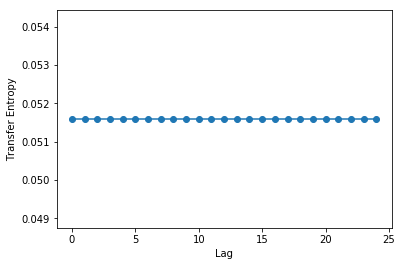

array([0.05159106, 0.05159106, 0.05159106, 0.05159106, 0.05159106,
       0.05159106, 0.05159106, 0.05159106, 0.05159106, 0.05159106,
       0.05159106, 0.05159106, 0.05159106, 0.05159106, 0.05159106,
       0.05159106, 0.05159106, 0.05159106, 0.05159106, 0.05159106,
       0.05159106, 0.05159106, 0.05159106, 0.05159106, 0.05159106])

In [44]:
analyser(P.astype(int),H.astype(int),maxlag =25,startid = 30,  name = 'PgivenH.pdf')

##### Interpretations

The information H brings to P seems to not decrease over time. This might be due to the inherent dynamics of H and P or the fact that a multiplicative constant has much more influence than an exponential decay or both.

### Modified NB model

We modify the previous model so that P doesnt have any influence on H

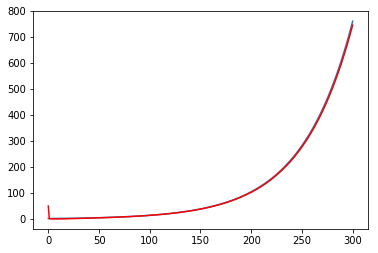

In [76]:
def mNBmodel(IC,steps =300):
    c = 1
    a = .5
    k =1.02
    H = np.zeros(steps+1)
    P = np.zeros(steps+1)
    H[0]= IC[0]
    P[0]= IC[1]
    for i in range(steps):
        H[i+1]= k*H[i]
        P[i+1]= c*H[i]*(1-np.exp(-a*P[i]))
    return H,P
mH,mP = mNBmodel([2,50])

plt.plot(mH)
plt.plot(mP,'r')
plt.show()

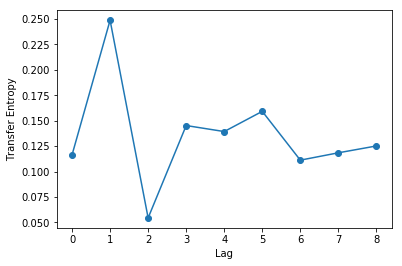

array([0.11638279, 0.24875469, 0.05443139, 0.14523996, 0.13933162,
       0.15918448, 0.11121831, 0.11844434, 0.12517283])

In [77]:
analyser(mP.astype(int),mH.astype(int),maxlag= 9,startid =10,name = 'mPgivenmH.pdf')

##### Interpretations

This makes sense because the biggest influence of P should be the previous time step of H.

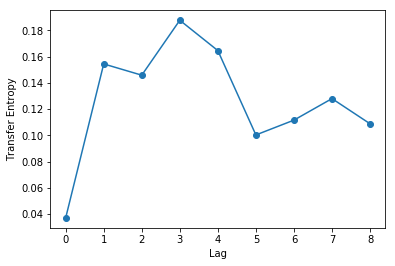

array([0.03711705, 0.15443309, 0.1458613 , 0.18771975, 0.16458641,
       0.10033076, 0.11161728, 0.12802155, 0.10885258])

In [78]:
analyser(mH.astype(int),mP.astype(int),maxlag= 9,startid =10,name = 'mHgivenmP.pdf')

##### Interpretations

This does not make any sense because H is supposed to be independent of P. So, this shows a clear failing of Transfer Entropy on discrete non-periodic dynamics

#### Lotka Volterra Dynamics

The Lotka Volterra dynamics are a good example because they are famous and they are periodic. Here, we adjust parameters to see a periodic setting and try transfer entropy on it.

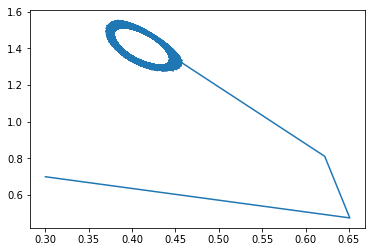

In [79]:
def LVmodel(IC, steps =2000, params = [4.1,1,2.93,0.2]):
    a,b,d,g =params
    x = np.zeros(steps+1)
    y = np.zeros(steps+1)
    x[0]= IC[0]
    y[0]= IC[1]
    for i in range(steps):
        x[i+1]= a*x[i]*(1-x[i]) -b*x[i]*y[i]
        y[i+1]= d*x[i]*y[i]-g*y[i]
    return x,y
H,P = LVmodel([0.3,0.7], params = [4.1,1,2.93,0.2])
plt.plot(H,P)
plt.show()

In [80]:
lvX = (100*H).astype(int)
lvY = (100*P).astype(int)

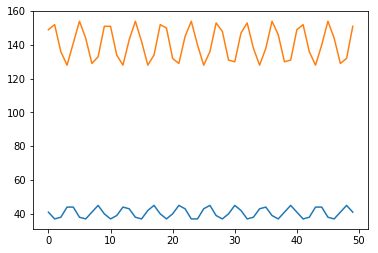

In [85]:
plt.plot(lvX[1000:1050])
plt.plot(lvY[1000:1050])
plt.show()

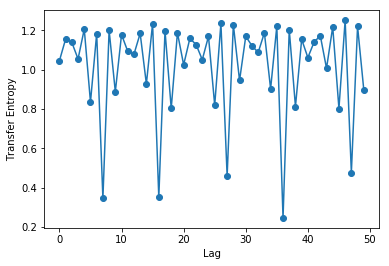

array([1.04537244, 1.15610406, 1.13853729, 1.05470816, 1.2060391 ,
       0.83555379, 1.18394151, 0.34594987, 1.20035122, 0.88810321,
       1.17861559, 1.09338046, 1.07858684, 1.18442308, 0.92770713,
       1.23438429, 0.35155825, 1.19767266, 0.80347619, 1.18789283,
       1.02495186, 1.15888912, 1.12793488, 1.05087597, 1.16959566,
       0.81952593, 1.23547984, 0.46030654, 1.22919254, 0.94515099,
       1.16958826, 1.12135401, 1.08778107, 1.18753142, 0.90293573,
       1.22111512, 0.2466    , 1.20316833, 0.81261416, 1.15426583,
       1.06161209, 1.14035023, 1.1731278 , 1.0072012 , 1.21733603,
       0.8027251 , 1.25142935, 0.47732796, 1.21966633, 0.89822213])

In [82]:
analyser(lvY,lvX,50,200)

##### Interpretations

At first glance, this looks periodic just like the dynamics, The Transfer Entropy dips at certain location with a period of 9-10 lags. This is the same lag as the period of our dynamics. the jumps are signficant from around 1 everywhere else to 0.2-0.4 around those locations. What that implies those time lags give very little information in predicting the next value. Two possible reasons are :
* either at those points, the previous value heavily determines the next one.
* or some resetting of the period happens there, which makes the new information useless

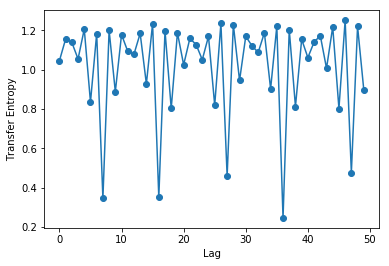

array([1.04537244, 1.15610406, 1.13853729, 1.05470816, 1.2060391 ,
       0.83555379, 1.18394151, 0.34594987, 1.20035122, 0.88810321,
       1.17861559, 1.09338046, 1.07858684, 1.18442308, 0.92770713,
       1.23438429, 0.35155825, 1.19767266, 0.80347619, 1.18789283,
       1.02495186, 1.15888912, 1.12793488, 1.05087597, 1.16959566,
       0.81952593, 1.23547984, 0.46030654, 1.22919254, 0.94515099,
       1.16958826, 1.12135401, 1.08778107, 1.18753142, 0.90293573,
       1.22111512, 0.2466    , 1.20316833, 0.81261416, 1.15426583,
       1.06161209, 1.14035023, 1.1731278 , 1.0072012 , 1.21733603,
       0.8027251 , 1.25142935, 0.47732796, 1.21966633, 0.89822213])

In [83]:
analyser(lvY,lvX,maxlag = 50,startid = 200)

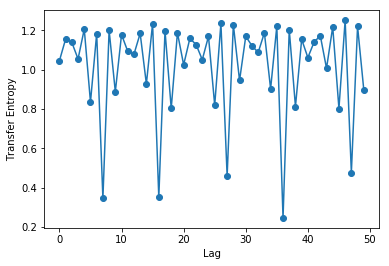

array([1.04537244, 1.15610406, 1.13853729, 1.05470816, 1.2060391 ,
       0.83555379, 1.18394151, 0.34594987, 1.20035122, 0.88810321,
       1.17861559, 1.09338046, 1.07858684, 1.18442308, 0.92770713,
       1.23438429, 0.35155825, 1.19767266, 0.80347619, 1.18789283,
       1.02495186, 1.15888912, 1.12793488, 1.05087597, 1.16959566,
       0.81952593, 1.23547984, 0.46030654, 1.22919254, 0.94515099,
       1.16958826, 1.12135401, 1.08778107, 1.18753142, 0.90293573,
       1.22111512, 0.2466    , 1.20316833, 0.81261416, 1.15426583,
       1.06161209, 1.14035023, 1.1731278 , 1.0072012 , 1.21733603,
       0.8027251 , 1.25142935, 0.47732796, 1.21966633, 0.89822213])

In [84]:
analyser(lvY,lvX,maxlag = 50,startid = 200)

#### Conclusions

We see that transfer entropy works best for discrete time dynamics on a finite set of states as seen in the Markov chain example and in [1]. The main contributor to that is that we use discrete settings for Transfer entropy. Perhaps, with a continuous version, we could get much better results for the other results.

The places where TE failed were in chaotic Lorenz dynamics made discrete and in the non-periodic Nicholson Bailey model. The lack of discreteness is a problem. However, a harder problem might lie in the fact that there are different dynamics for different parameters. To understand causation, transfer entropy might need to be extended to different bifurcation regimes to get clear causation plots.

One place where TE gives some information is periodic discrete dynamics. The dip in transfer entropy indicates